In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter
from brokenaxes import brokenaxes
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
from shapely.geometry import Point, box
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
from functools import reduce
proj = ccrs.PlateCarree()

#Plotting with h3 uber 
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import RobustScaler
import h3

#Masking array
from rechunker import rechunk
from rasterio import features
from affine import Affine
from shapely.geometry import Point
from shapely.geometry import Polygon

#External functions 
import fct.fct_plot_claims as fct_plot_claims
import fct.preprocess_sinclim as preprocess_sinclim
from fct.paths import *
path_save_fig = '/home/users/lhasbini/figures/cluster_impact/'

In [6]:
FRA_geo_shp = gpd.read_file(os.path.join(PATH_SHP_COUNTRIES, "world-administrative-boundaries_FRA_level0.shp"))

## Open tracks with impact 

In [7]:
# PATH_TRACKS = "/home/estimr3/lhasbini/data_storm/priestley/convert_TE/"

period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"NH_ALL/tracks_ALL_24h_1979-2024WIN_info_SSI-wgust-v2_r1300.csv", encoding="utf-8")
df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

4439 number of storms


In [8]:
########## IMPACT DATA 
path_generali  = "/home/users/lhasbini/data_generali/"
window        = 'd-3_d+3'
min_claim     = 50
method        = 'wgust'
r             = 1300

sinclim = preprocess_sinclim.open_sinclim_associated(path_generali, window, min_claim, method, period, r)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]

In [9]:
######## Group the impact data over storm events
sinclim = sinclim.loc[sinclim.storm_id.isin(df_info_storm_impact.storm_id.unique())]
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')
sinclim_storm = sinclim.groupby(['storm_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
    NDR_6h_max   =('NDR_6h_max', 'first'), 
    NDR_24h_max  =('NDR_24h_max', 'first')).reset_index()#, 
#     SSI_FRA_max = ('SSI_FRA', 'first')).reset_index()

In [10]:
########## High-Impact storm clusters
windi = 96
r     = 700

df_storm_cluster                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+".csv", encoding='utf-8')
df_info_mult_cluster                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+"_info.csv", encoding='utf-8')
df_info_mult_cluster['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster['storm_landing_date'])

df_info_mult_cluster = pd.merge(df_info_mult_cluster, df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

In [11]:
######## Group the impact data over cluster events 
sinclim_clust = sinclim.loc[sinclim.storm_id.isin(df_info_mult_cluster.storm_id.unique())]
sinclim_clust = pd.merge(sinclim_clust, df_info_mult_cluster[["storm_id", "clust_id"]], on='storm_id', how='left')

######## Group the impact data over storm events
sinclim_storm_grp = sinclim_clust.groupby(['storm_id', 'clust_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
    NDR_6h_max   =('NDR_6h_max', 'first'), 
    NDR_24h_max  =('NDR_24h_max', 'first'), 
    SSI_FRA_max = ('SSI_FRA', 'first')).reset_index()

sinclim_clust_grp = sinclim_clust.groupby('clust_id').agg(
    year = ('year', 'first'),
    num_chg_brut =('num_chg_brut_cst', 'sum')).reset_index()

# Footprint - Physical events 

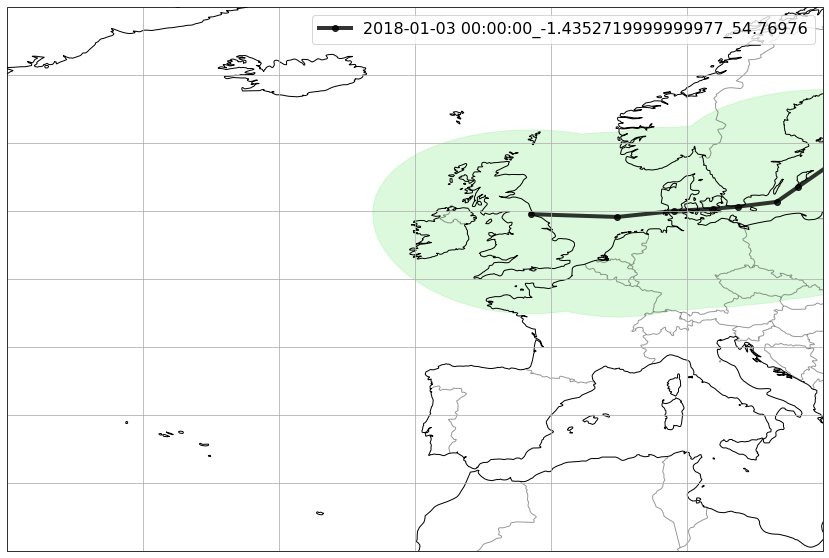

In [12]:
stormi_main = '2018-01-03 00:00:00_-1.4352719999999977_54.76976'
df_info_plot = df_info_storm.loc[df_info_storm.storm_id==stormi_main]
df_plot = df_storm.loc[df_storm.storm_id==stormi_main]

#Prepare buffer
gdf_tracks = gpd.GeoDataFrame(
        df_plot,
        geometry=gpd.points_from_xy(df_plot.lon, df_plot.lat),
        crs="EPSG:4326"
    )
gdf_tracks['buffer'] = gdf_tracks.to_crs(epsg=3395).geometry.buffer(1300 * 1000).to_crs(epsg=4326)
spatial_index = gdf_tracks.sindex

polygons = []
fig = plt.figure(figsize=[15, 10])
ax = plt.subplot(1, 1, 1, projection = proj)
ax.set_extent([-40, 20, 30, 70], crs=proj)
ax._autoscaleXon = False
ax._autoscaleYon = False

#Buffer the storm 
storm_buffer = gdf_tracks.loc[gdf_tracks['storm_id'] == stormi_main, 'buffer'].values
union_buffer = unary_union(storm_buffer)
if isinstance(union_buffer, MultiPolygon):
    print(len(union_buffer))
    #polygons.append(union_buffer[0])
    union_buffer = union_buffer[1]
else :
    polygons.append(union_buffer)

#Plot the trajectory and the buffer
x, y = union_buffer.exterior.xy

ax.plot(df_plot['lon'], df_plot['lat'], '-o', alpha = 0.8, color = "black", 
    linewidth=4, label=stormi_main)
plt.fill(x, y, alpha=0.3, color='lightgreen')

geo_series = gpd.GeoSeries(polygons)

ax.coastlines()
ax.gridlines()
ax.add_feature(cf.BORDERS, linestyle='-', alpha=0.4)
ax.legend(fontsize=16)
# fig.savefig(path_save_fig+"Storm_"+str(stormi_main)+".png", transparent=True, bbox_inches='tight')

<ipython-input-13-375b17539120>:80: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


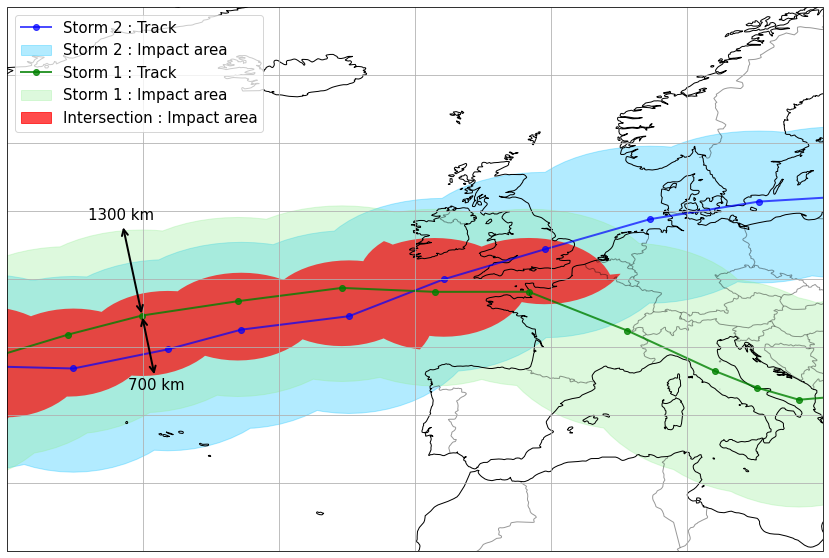

In [13]:
stormi_main = "2007-01-01 12:00:00_-6.4436039999999934_49.054977"#"2023-11-01 06:00:00_-7.313476999999978_53.300968"
clusti_test = df_info_mult_cluster.loc[df_info_mult_cluster.storm_id==stormi_main].clust_id.unique()
df_info_plot = df_info_mult_cluster.loc[df_info_mult_cluster.clust_id.isin(clusti_test)]
df_plot = df_storm_cluster.loc[df_storm_cluster.storm_id.isin(df_info_plot.storm_id.unique())]

#Prepare buffer
gdf_tracks = gpd.GeoDataFrame(
        df_plot,
        geometry=gpd.points_from_xy(df_plot.lon, df_plot.lat),
        crs="EPSG:4326"
    )
gdf_tracks['buffer'] = gdf_tracks.to_crs(epsg=3395).geometry.buffer(1100 * 1000).to_crs(epsg=4326)
gdf_tracks['buffer_intersec'] = gdf_tracks.to_crs(epsg=3395).geometry.buffer(700 * 1000).to_crs(epsg=4326)
spatial_index = gdf_tracks.sindex

for clusti in clusti_test : 
    polygons = []
    polygons_intersect = []
    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(1, 1, 1, projection = proj)
    ax.set_extent([-40, 20, 30, 70], crs=proj)
    ax._autoscaleXon = False
    ax._autoscaleYon = False
    storm_id_clust = df_info_plot.loc[df_info_plot.clust_id==clusti].storm_id
    for id_s, stormi in enumerate(storm_id_clust) : 
        storm_plot = df_plot.loc[df_plot.storm_id == stormi]
        #Buffer the storm 
        storm_buffer = gdf_tracks.loc[gdf_tracks['storm_id'] == stormi, 'buffer'].values
        storm_buffer_intersect = gdf_tracks.loc[gdf_tracks['storm_id'] == stormi, 'buffer_intersec'].values
        union_buffer = unary_union(storm_buffer)
        union_buffer_intersect = unary_union(storm_buffer_intersect)
        if isinstance(union_buffer, MultiPolygon):
            union_buffer = union_buffer[1]
        else :
            polygons.append(union_buffer)
            polygons_intersect.append(union_buffer_intersect)
            
        #Plot the trajectory and the buffer
        x, y = union_buffer.exterior.xy        
        if stormi == stormi_main : 
            ax.plot(storm_plot['lon'], storm_plot['lat'], '-o', alpha = 0.8, color = "green", 
                linewidth=2, label="Storm 1 : Track")
            plt.fill(x, y, alpha=0.3, color='lightgreen', label="Storm 1 : Impact area")
        else : 
            ax.plot(storm_plot['lon'], storm_plot['lat'], '-o', alpha = 0.7, color = 'blue',
                linewidth=2, label="Storm 2 : Track")
            plt.fill(x, y, alpha=0.3, color='deepskyblue', label="Storm 2 : Impact area")
            
    
    # Extract Storm 1 center coordinates
    storm1_lon = df_plot.loc[df_plot.storm_id == stormi_main, 'lon'].values[4]
    storm1_lat = df_plot.loc[df_plot.storm_id == stormi_main, 'lat'].values[4]

    # Define arrow properties
    arrow_props = dict(arrowstyle="<->", color="black", linewidth=2)

    # Annotate radius of Storm 1's impact area (1100 km)
    ax.annotate("1300 km", 
                xy=(storm1_lon, storm1_lat),  # Adjust offset
                xytext=(storm1_lon -4, storm1_lat+7), 
                arrowprops=arrow_props,
                fontsize=15, color="black")

    # Annotate radius of Intersection (700 km)
    ax.annotate("700 km", 
                xy=(storm1_lon, storm1_lat),  
                xytext=(storm1_lon-1, storm1_lat-5.5), 
                arrowprops=arrow_props,
                fontsize=15, color="black")

    
    #Intersection
    geo_series = gpd.GeoSeries(polygons_intersect)
    intersection = reduce(lambda p1, p2: p1.intersection(p2), geo_series)
    gpd.GeoSeries(intersection).plot(ax=ax, color='red', alpha=0.7, label="Intersection : Impact area")
    
    # Legend
    from matplotlib.patches import Patch
    impact_area_patches  = [Patch(color='red', alpha=0.7, label="Intersection : Impact area")]
    handles, labels = ax.get_legend_handles_labels()
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cf.BORDERS, linestyle='-', alpha=0.4)
    ax.legend(handles + impact_area_patches, labels + [p.get_label() for p in impact_area_patches], loc="upper left", fontsize=15)
#     fig.savefig(path_save_fig+"Cluster_illustration.png", transparent=True, bbox_inches='tight')
#     fig.savefig(path_save_fig+"Cluster_illustration.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)

# Footprint - Physical event + Damage

## Cluster Anatol/Lothar/Martin

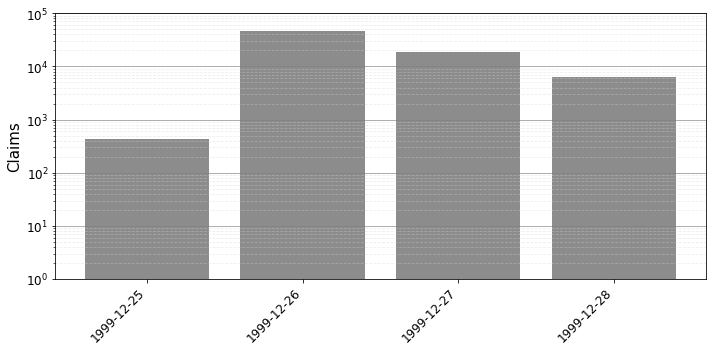

In [12]:
### Only raw claim dates
first_date  = datetime.datetime(year=1999, month=12, day=25)
last_date   = datetime.datetime(year=1999, month=12, day=28)
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]

sinclim_subset_by_day = sinclim_subset.groupby("dat_sin").agg(num_chg_brut_tot = ('num_chg_brut', 'sum'),
                                                   nb_claims           = ('cod_sin', 'count')).reset_index()

# Plot original and concentrated claims
fig = plt.figure(figsize=(10, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.4)

# Labels and title
plt.ylabel('Claims', fontsize=15)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# fig.savefig(path_save_fig+'nb_claims_days', 
#             transparent=True, bbox_inches='tight', dpi=400)
# fig.savefig(path_save_fig+'nb_claims_days.svg', 
#             format="svg", bbox_inches="tight", dpi=400, transparent=True)

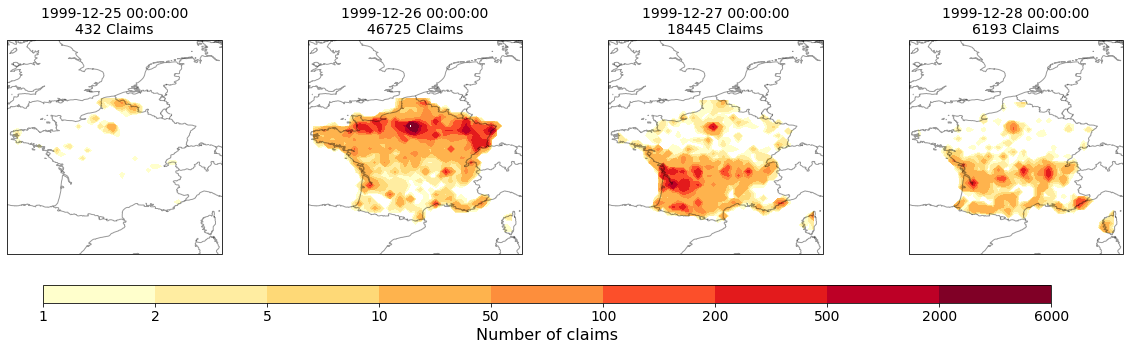

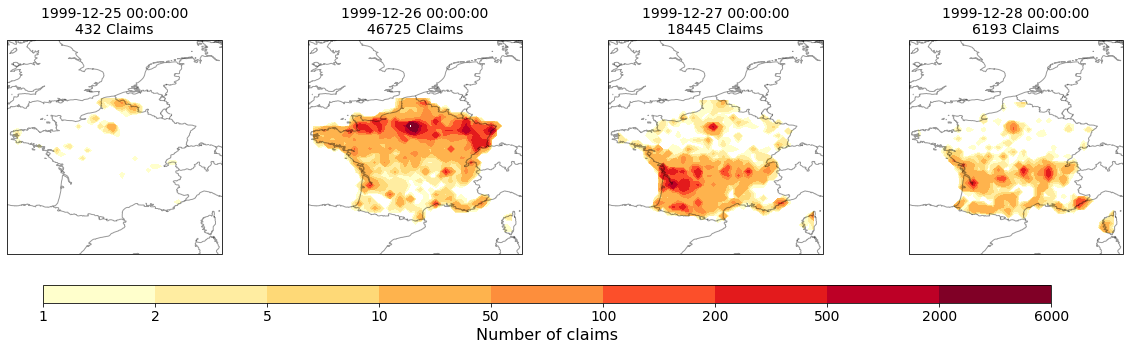

In [14]:
fct_plot_claims.plot_nbclaims(sinclim_subset, sinclim_subset_by_day.dat_sin, False, path_save_fig)

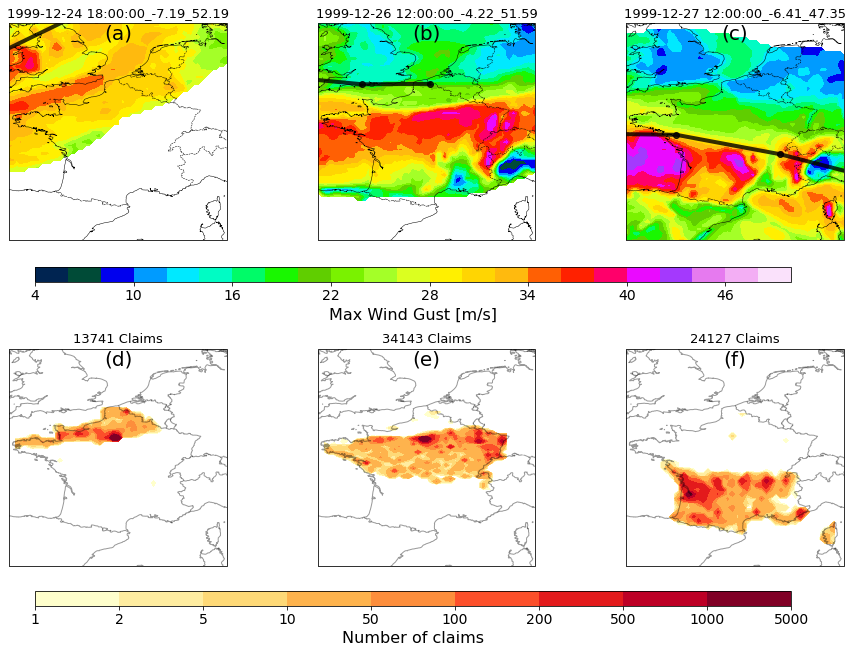

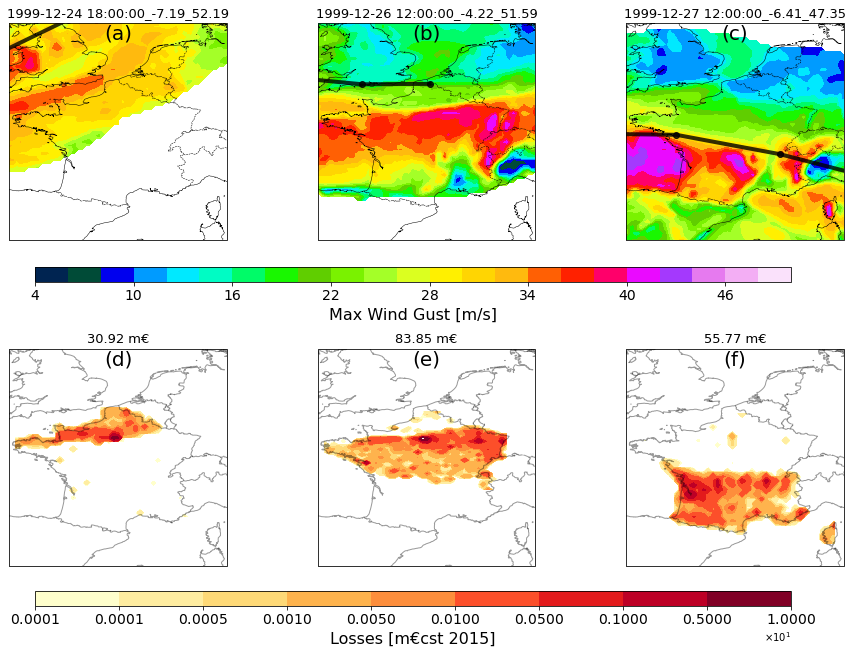

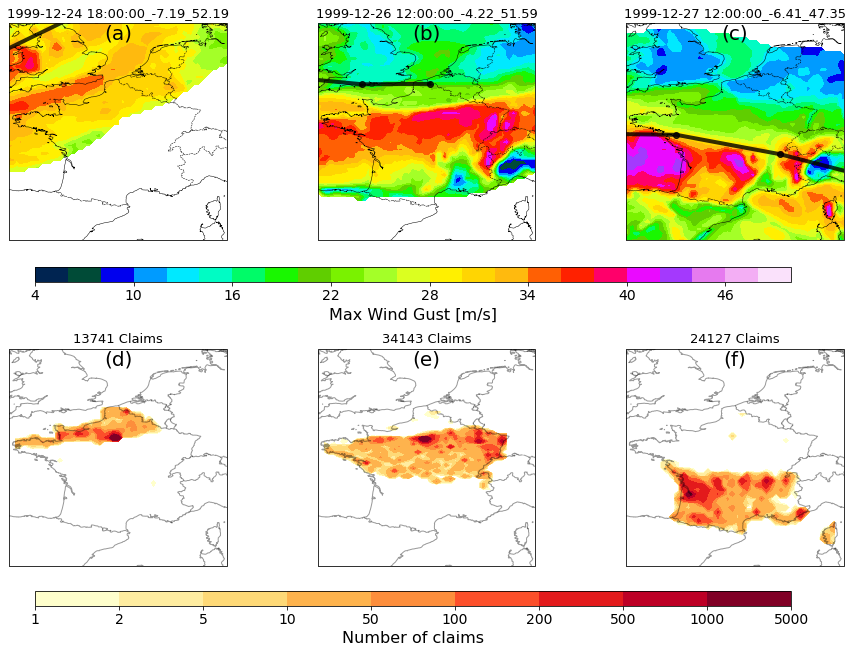

In [14]:
fct_plot_claims.plot_cluster_wind_losses(df_storm, sinclim_storm_grp, sinclim, 9, PATH_FOOTPRINTS, save=False, path_save_fig = path_save_fig, method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")
fct_plot_claims.plot_cluster_wind_nbclaims(df_storm, sinclim_storm_grp, sinclim, 9, PATH_FOOTPRINTS, save=False, path_save_fig = path_save_fig, method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")

## Cluster with Klaus 

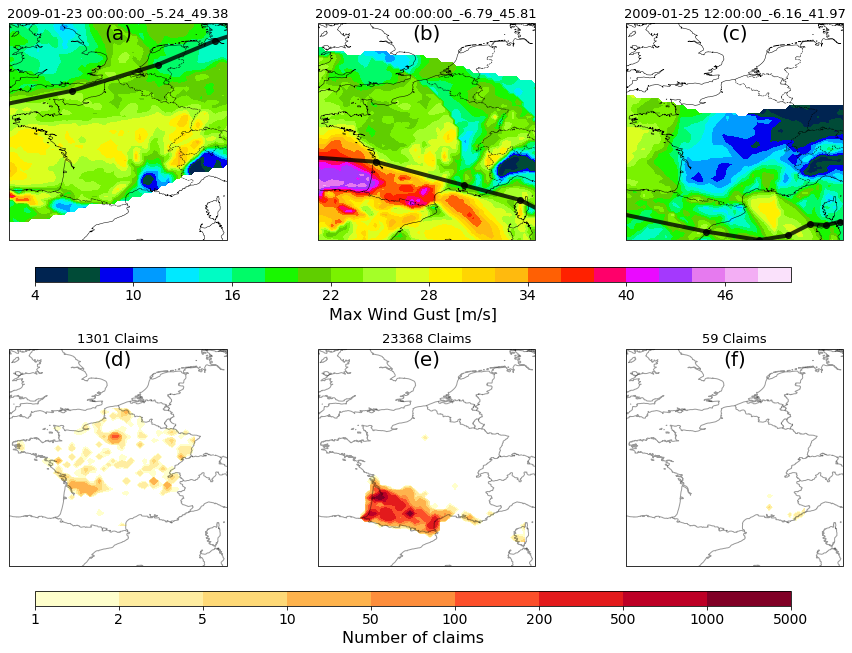

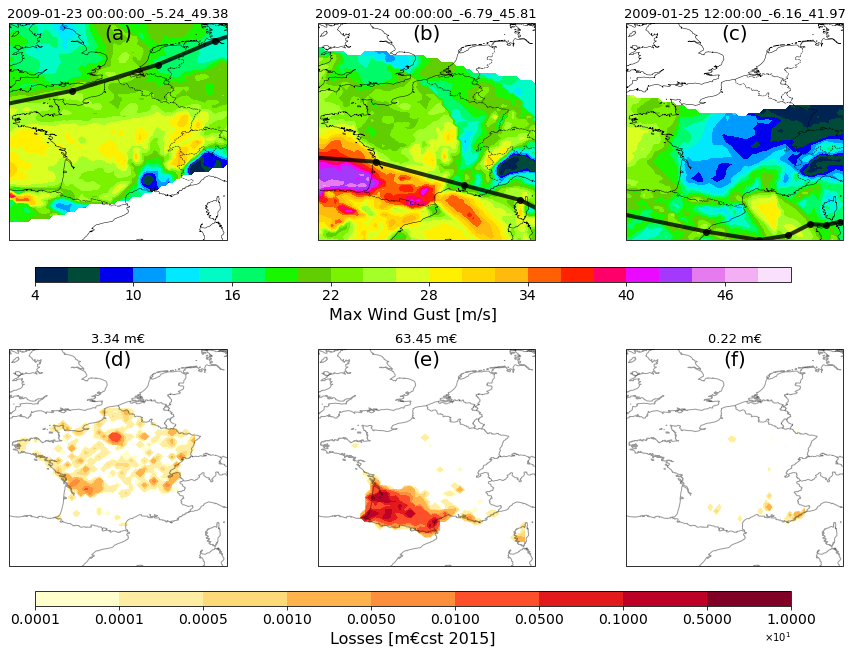

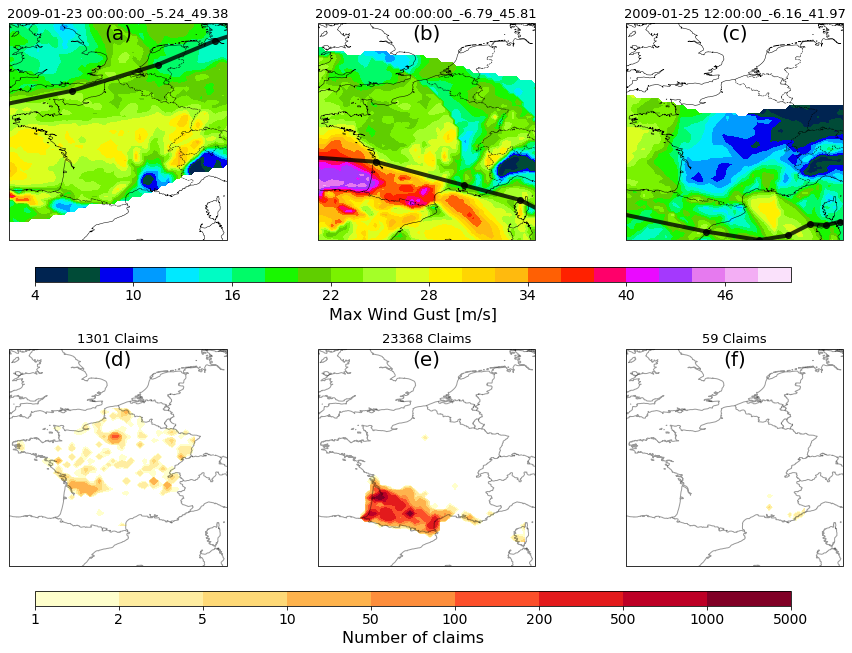

In [16]:
fct_plot_claims.plot_cluster_wind_losses(df_storm, sinclim_storm_grp, sinclim, 109, PATH_FOOTPRINTS, save=False, path_save_fig = path_save_fig, method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")
fct_plot_claims.plot_cluster_wind_nbclaims(df_storm, sinclim_storm_grp, sinclim, 109, PATH_FOOTPRINTS, save=False, path_save_fig = path_save_fig, method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")